# Updated Road Home analysis (Orleans, St. Bernard and combined)

### Note: All race, poverty and income statistics come from IPUMS

### Merging data files
Data files:
- rh: Road Home data provided by the state of Louisiana. Aggregated to block level for blocks with more than 5 Road Home grantees
- flood_blocks: Flooding statistics by block to allow Road Home data to be collected only for blocks with more than 3 feet of flooding
- blocks_race: Census 2000 demographics (not currently used in this analysis)
- households: Census 2000 household demographics (not currently used in this analysis)
- income: Census 2000 IPUMS income, poverty and race data. Aggregated by block group
- bg_shp: Census 2000 Tiger/Line shapefile of block groups in Orleana and St. Bernard Parish for visualization. Water bodies have been removed using parish-level (Orleans, Jefferson, St. Bernard, St. Tammany, Plaquemines) Tiger/Line Area Hydrography

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
rh = pd.read_csv('raw data/PRR 8_22_22.csv')
rh = rh.rename(columns = {'Census Block' : 'GEOID'})
rh['GEOID'] = rh['GEOID'].astype(str)
rh = rh.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }
)


# Import flooding statistics by Census block and generate list of GEOIDs with greater than 3 feet of flooding for filtering
flood_blocks = gpd.read_file('shapefiles/flood_blocks_all/flood_blocks_all.shp')
flood_blocks = flood_blocks[['BLKIDFP00', 'flood_mean', 'flood_medi', 'flood_min', 'flood_max']]
flood_blocks = flood_blocks.rename(columns = {'BLKIDFP00' : 'GEOID', 'flood_medi' : 'flood_median'})
flood_blocks['GEOID'] = flood_blocks['GEOID'].astype(str)
flood_blocks_GT3 = flood_blocks[flood_blocks['flood_min'] > 3]['GEOID'].to_list()

blocks_race = pd.read_csv('raw data/2000-La-HispanicRaceByBlock.csv', skiprows=[0])

# Rename relevant columns for easy reference
blocks_race = blocks_race.rename(
    columns = {
        'Total!!Hispanic or Latino' : 'Hispanic',
        'Total!!Not Hispanic or Latino!!Population of one race!!White alone' : 'White',
        'Total!!Not Hispanic or Latino!!Population of one race!!Black or African American alone' : 'Black',
        'Total!!Not Hispanic or Latino!!Population of one race!!American Indian and Alaska Native alone' : 'Indigenous',
        'Total!!Not Hispanic or Latino!!Population of one race!!Asian alone' : 'Asian',
        'Total!!Not Hispanic or Latino!!Population of one race!!Native Hawaiian and Other Pacific Islander alone' : 'NHOPI',
        'Total!!Not Hispanic or Latino!!Population of one race!!Some other race alone' : 'Other',
        'Total!!Not Hispanic or Latino!!Population of two or more races' : 'Multiracial'
    })
blocks_race = blocks_race[['Total', 'White', 'Black', 'Hispanic', 'Indigenous', 'Asian', 'NHOPI', 'Other', 'Multiracial', 'Geography']]

blocks_race['GEOID'] = blocks_race['Geography'].apply(lambda x: x.split('US')[1])

# Import household statistics based on 2000 Census
households = pd.read_csv('raw data/2000-La-TenureByHouseholderRaceByBlock.csv', skiprows=[0])
households['GEOID'] = households['Geography'].apply(lambda x: x.split('US')[1])
households = households[['GEOID', 'Total', 'Total!!Owner occupied', 'Total!!Owner occupied!!Householder who is Black or African American alone']]
households = households.rename(
    columns =
        {
            'Total' : 'households_2000_total',
            'Total!!Owner occupied' : 'households_2000_owner_occupied',
            'Total!!Owner occupied!!Householder who is Black or African American alone' : 'households_2000_owner_occupied_black'
        })

income = pd.read_csv('processed data/rh_block_groups_all_LA_income_poverty_race_table_3.csv')
income['GEOID'] = income['GEOID'].astype(str)
income = income.rename(columns=
                        {"HAK001": "total_pop",
                        "HA2001":"total_households",
                        "HAQ001": "not_hispanic",
                        "HAQ002": "hispanic",
                        "HAR001":"not_hispanic_white",
                        "HAR002":"not_hispanic_black",
                        "HAR003":"not_hispanic_native",
                        "HAR004":"not_hispanic_asian",
                        "HAR005":"not_hispanic_pacific_islander",
                        "HAR006":"not_hispanic_other",
                        "HAR007":"not_hispanic_two_or_more",
                        "HAR008":"hispanic_white",
                        "HAR009":"hispanic_black",
                        "HAR010":"hispanic_native",
                        "HAR011":"hispanic_asian",
                        "HAR012":"hispanic_pacific_islander",
                        "HAR013":"hispanic_other",
                        "HAR014":"hispanic_two_or_more",
                        "HF5001":"hh_lt_10000",
                        "HF5002":"hh_10000_1499",
                        "HF5003":"hh_15000_19999",
                        "HF5004":"hh_20000_24,999",
                        "HF5005":"hh_25000_29999",
                        "HF5006":"hh_30000_34999",
                        "HF5007":"hh_35000_39999",
                        "HF5008":"hh_40000_44999",
                        "HF5009":"hh_45000_49999",
                        "HF5010":"hh_50000_59999",
                        "HF5011":"hh_60000_74999",
                        "HF5012":"hh_75000_99999",
                        "HF5013":"hh_100000_124999",
                        "HF5014":"hh_125000_149999",
                        "HF5015":"hh_150000_199999",
                        "HF5016":"hh_gte_200000",
                        "HF6001":"hh_median_income",
                        "HHE001":"persons_below_poverty_level",
                        "HHE002":"persons_at_or_below_poverty_level",
                        "HHS001":"hh_below_poverty_level",
                        "HHS002":"hh_at_or_below_poverty_level"}
                    )

rh_flood = (rh[rh['GEOID'].isin(flood_blocks_GT3)]
            .merge(flood_blocks, on='GEOID', how='outer')
            .merge(blocks_race, on='GEOID', how='outer')
            .merge(households, on='GEOID', how='outer'))
rh_flood['CNTYIDFP00'] = rh_flood['GEOID'].str[:5]
rh_flood['BKGPIDFP00'] = rh_flood['GEOID'].str[:12]
rh_flood['TRACTIDFP00'] = rh_flood['GEOID'].str[:11]

In [3]:
print("Checking to ensure blocks match properly.")
print("")
print(f"Total flood blocks: {len(flood_blocks):,.0f}")
print(f"Blocks with more than 3 feet of flooding (flood blocks): {len(flood_blocks[flood_blocks['flood_min']>3]):,.0f}")
print(f"Total RH blocks: {len(rh_flood):,.0f}")
print(f"Total RH blocks where compensation_sum is not null: {len(rh_flood[rh_flood['compensation_sum'].notnull()]):,.0f}")
print(f"Total RH blocks where total pop is not null: {len(rh_flood[rh_flood['Total'].notnull()]):,.0f}")
print(f"Total RH blocks where households total is not null: {len(rh_flood[rh_flood['households_2000_total'].notnull()]):,.0f}")
print(f"RH blocks with more than 3 feet of flooding: {len(rh_flood[rh_flood['flood_min']>3]):,.0f}")
print(f"Total combined blocks: {len(rh_flood):,.0f}")

Checking to ensure blocks match properly.

Total flood blocks: 139,867
Blocks with more than 3 feet of flooding (flood blocks): 2,943
Total RH blocks: 139,867
Total RH blocks where compensation_sum is not null: 1,617
Total RH blocks where total pop is not null: 139,867
Total RH blocks where households total is not null: 139,867
RH blocks with more than 3 feet of flooding: 2,943
Total combined blocks: 139,867


In [4]:
rh_flood = rh_flood.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }
)

In [57]:
agg_fields = [
    'compensation_sum',
    'additional_compensation_sum',
    'elevation_sum', 
    'mitigation_sum', 
    'all_grants_sum', 
    'all_grants_count',
    'pre_storm_value_sum', 
    'damage_sum', 
    'insurance_sum',
    'Total', 
    'White', 
    'Black', 
    'Hispanic', 
    'Indigenous', 
    'Asian', 
    'NHOPI',
    'Other', 
    'Multiracial',
    'households_2000_total',
    'households_2000_owner_occupied',
    'households_2000_owner_occupied_black',
]

def helper_fields(df):
    df['damage_mean'] = df['damage_sum'] / df['all_grants_count']
    df['grant_insurance_sum'] = df['compensation_sum']+df['additional_compensation_sum']+df['insurance_sum']
    df['grant_insurance_mean'] = df['grant_insurance_sum']/df['all_grants_count']
    df['uncovered_sum'] = df['damage_sum'] - df['grant_insurance_sum']
    df['uncovered_mean'] = df['uncovered_sum']/df['all_grants_count']
    df['uncovered_percent'] = (df['damage_sum']-df['grant_insurance_sum'])/df['damage_sum']
    df['pre_storm_value_mean'] = (df['pre_storm_value_sum']/df['all_grants_count'])
    # NOTE: white_percent is calculated using Table 3 IPUMS data
    df['white_percent'] = df['not_hispanic_white']/df['total_pop']
    df['rh_household_pct'] = df['all_grants_count']/df['households_2000_owner_occupied']
    df['households_2000_owner_occupied_pct'] = df['households_2000_owner_occupied']/df['households_2000_total']
    df['households_2000_owner_occupied_black_pct'] = df['households_2000_owner_occupied_black']/df['households_2000_total']
    df['percent_poverty_status'] = df['hh_below_poverty_level']/df['total_households']
    # Buyouts are not yet part of this analysis. Still working on cleaning the St. Bernard geocoding.
    # df['buyouts_households_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']
    # df['buyouts_owner_occupied_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']

    return df

In [67]:
rh_bg = rh_flood.groupby('BKGPIDFP00')[agg_fields].sum()
rh_bg = rh_bg.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
rh_bg = helper_fields(rh_bg)
rh_bg['CNTYIDFP00'] = rh_bg['GEOID'].str[:5]
rh_bg['hh_median_income_bin'] = pd.cut(rh_bg['hh_median_income'], bins=[0,20000,40000,60000,80000,100000,110000])
rh_bg['hh_median_income_quint'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg['hh_median_income_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071']) & (rh_bg['compensation_sum']>0))]['hh_median_income'], q=5)
rh_bg['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)

rh_bg['percent_poverty_bins'] = pd.cut(rh_bg['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1])
rh_bg['percent_poverty_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_bg['percent_poverty_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_bg['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_bg['white_percent_bins'] = pd.cut(rh_bg['white_percent'], bins=[0,.2,.4,.6,.8,1])
rh_bg['white_percent_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['white_percent'], q=5)
rh_bg['white_percent_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_bg['white_percent_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')



In [68]:
bg_shp = gpd.read_file('shapefiles/block_groups/orleans_stbernard_bg_no_water.shp')
# rh_bg = bg_shp[['geometry', 'BKGPIDFP00']].merge(rh_bg, left_on='BKGPIDFP00', right_on='GEOID')


In [69]:
rh_bg = bg_shp.merge(rh_bg, left_on='BKGPIDFP00', right_on='GEOID', how='outer')

## Maps
### Note: These maps are on the block group level, not neighborhood level, to allow comparison between Orleans and St. Bernard (which doesn't have Census-based neighborhods)

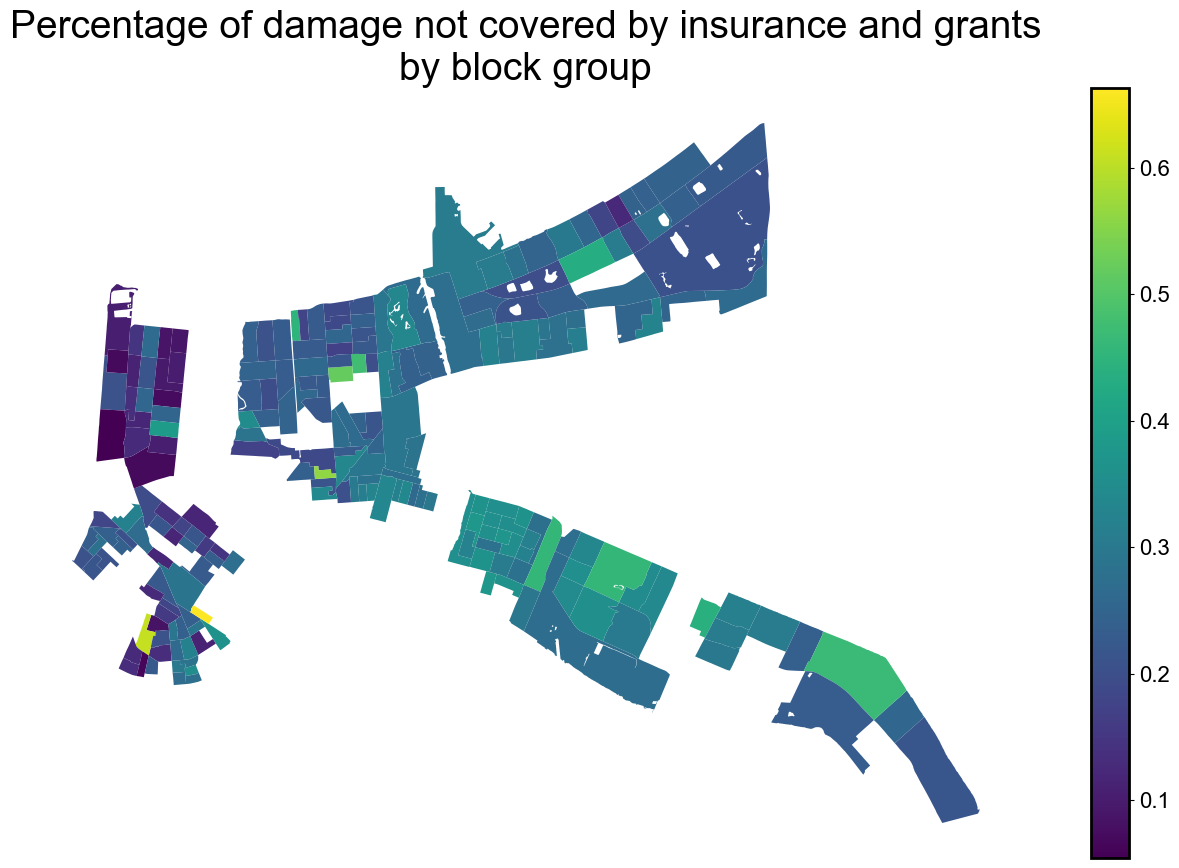

In [70]:
fig, ax = plt.subplots(figsize=(17,10))
rh_bg[rh_bg['all_grants_count']>0].plot(column='uncovered_percent', ax=ax, legend=True)
plt.title('Percentage of damage not covered by insurance and grants\nby block group')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

## Orleans versus St. Bernard

Orleans and St. Bernard have very different income/poverty characteristics, which makes comparing them difficult. Additionally, St. Bernard's block groups are much more homogenous in terms of income, with about $43,000 separating the median income of the highest and lowest income block groups. Orleans, by contrast, has more than $100,000 difference in median income between its highest and lowest income block groups

In [71]:
display(pd.concat([
    rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').size().rename('Orleans'),
    rh_bg[rh_bg['CNTYIDFP00']=='22087'].groupby('hh_median_income_quint').size().rename('St. Bernard')
], axis=1))


print(f"Orleans Parish has a minimum hh median income of ${rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['compensation_sum']>0)]['hh_median_income'].min():,.0f} and a maximum of ${rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['compensation_sum']>0)]['hh_median_income'].max():,.0f}")
print(f"St. Bernard Parish has a minimum hh median income of ${rh_bg[(rh_bg['CNTYIDFP00']=='22087') & (rh_bg['compensation_sum']>0)]['hh_median_income'].min():,.0f} and a maximum of ${rh_bg[(rh_bg['CNTYIDFP00']=='22087') & (rh_bg['compensation_sum']>0)]['hh_median_income'].max():,.0f}")

,Orleans,St. Bernard
hh_median_income_quint,,
"(7444.999, 18650.0]",44,0
"(18650.0, 25997.2]",43,1
"(25997.2, 34621.2]",35,8
"(34621.2, 44833.6]",38,6
"(44833.6, 109861.0]",37,7


Orleans Parish has a minimum hh median income of $7,445 and a maximum of $109,861
St. Bernard Parish has a minimum hh median income of $23,750 and a maximum of $67,067


## Median Income versus Poverty Status

Whether using Median Income or Poverty Status, the general trend is toward higher income block groups having less uncovered damage. Several outlier block groups (one in New Orleans and 2 in St. Bernard) which are high income AND high uncovered damage muddy the picture somewhat, particularly when using bins rather than quintiles. There is no clear reason what would make these block groups different than others with similar characteristics.

Poverty provides a cleaner relationship with uncovered damage when looking at all block groups in Orleans and St. Bernard.

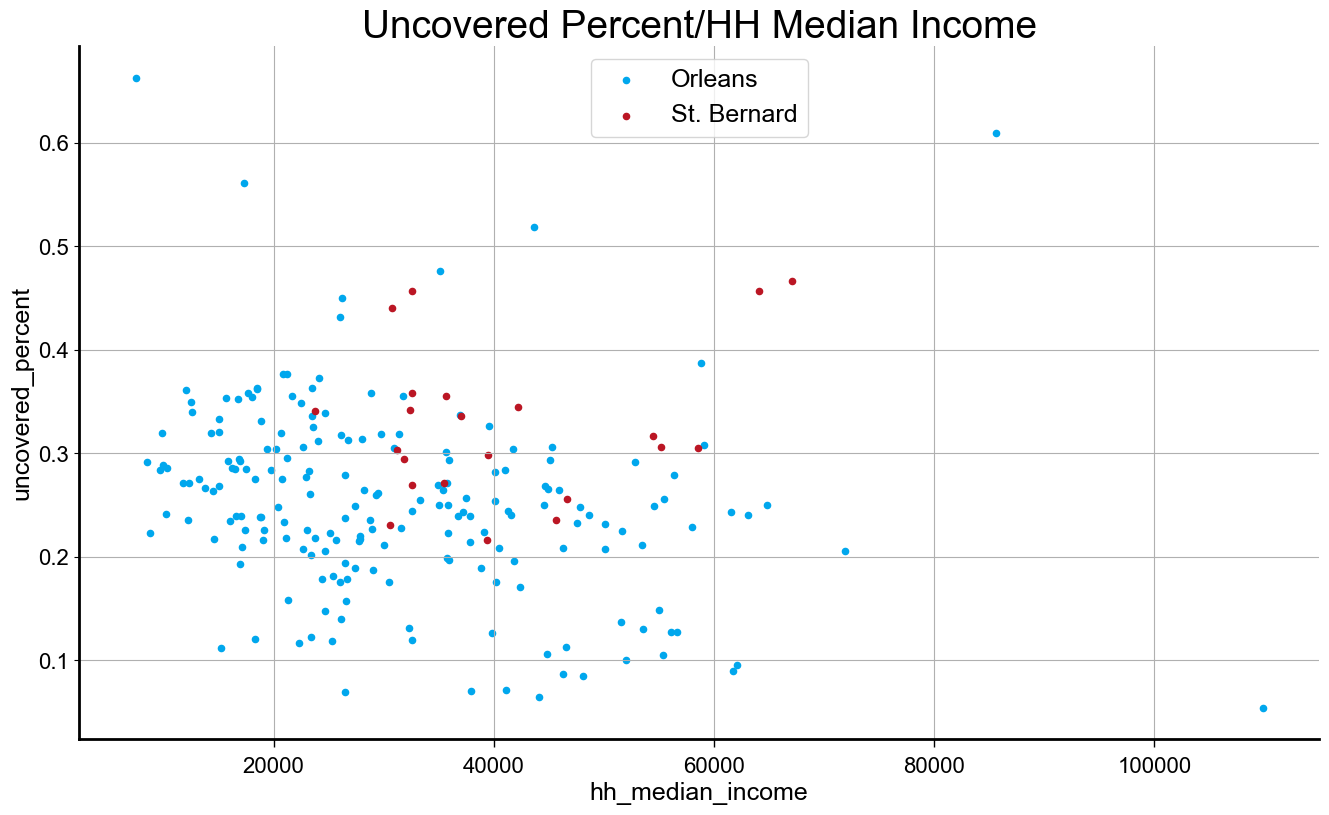

In [150]:
fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00']=='22071'].plot(kind='scatter', x='hh_median_income',  y='uncovered_percent', label='Orleans', ax = ax, color='C0')
rh_bg[rh_bg['CNTYIDFP00']=='22087'].plot(kind='scatter',  x='hh_median_income', y='uncovered_percent', label='St. Bernard', ax = ax, color='C1')
plt.title('Uncovered Percent/HH Median Income')
plt.legend(loc='upper center')
plt.show()
plt.close()

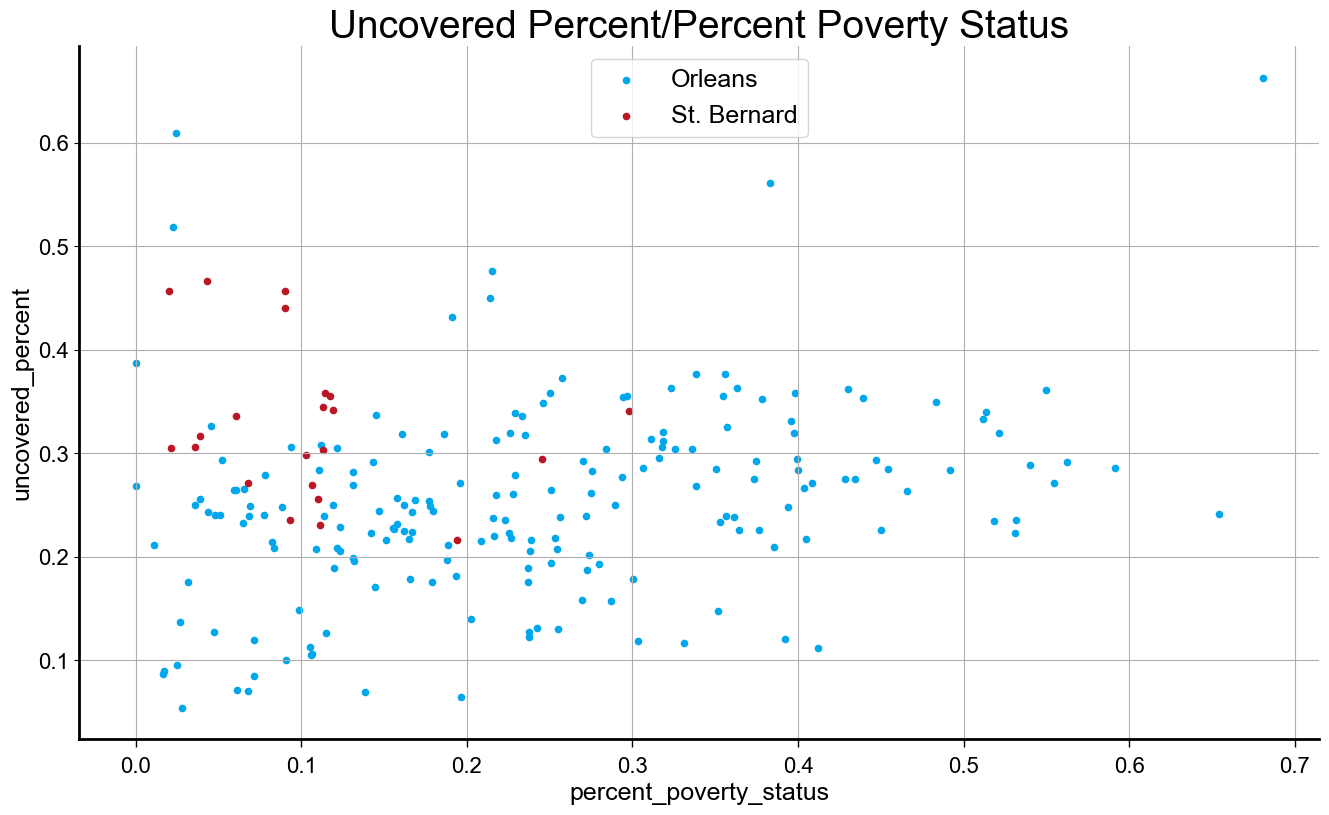

In [152]:
fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00']=='22071'].plot(kind='scatter', x='percent_poverty_status',  y='uncovered_percent', label='Orleans', ax = ax, color='C0')
rh_bg[rh_bg['CNTYIDFP00']=='22087'].plot(kind='scatter',  x='percent_poverty_status', y='uncovered_percent', label='St. Bernard', ax = ax, color='C1')
plt.title('Uncovered Percent/Percent Poverty Status')
plt.legend(loc='upper center')
plt.show()
plt.close()

In [72]:
# print(f"Uncovered percent for block groups with less than 25% percent poverty rate: {rh_bg[rh_bg['percent_poverty_status']<.25]['uncovered_sum'].sum()/rh_bg[rh_bg['percent_poverty_status']<.25]['damage_sum'].sum():.2%}")
# print(f"Uncovered percent for block groups with less than 50% percent poverty rate: {rh_bg[rh_bg['percent_poverty_status']<.50]['uncovered_sum'].sum()/rh_bg[rh_bg['percent_poverty_status']<.50]['damage_sum'].sum():.2%}")
# print(f"Uncovered percent for block groups with more than 50% percent poverty rate: {rh_bg[rh_bg['percent_poverty_status']>.50]['uncovered_sum'].sum()/rh_bg[rh_bg['percent_poverty_status']>.50]['damage_sum'].sum():.2%}")

print('Including all block groups.')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('percent_poverty_bins').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('percent_poverty_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('percent_poverty_quint').size().rename('Count')
    ], axis=1))

    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_bin').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_quint').size().rename('Count')
    ], axis=1))



Including all block groups.


,Uncovered Percent,Count
percent_poverty_bins,,
"(0.0, 0.2]",0.26,105
"(0.2, 0.4]",0.28,86
"(0.4, 0.6]",0.29,25
"(0.6, 0.8]",0.34,2
"(0.8, 1.0]",NaN,0


,Uncovered Percent,Count
percent_poverty_quint,,
"(-0.001, 0.0906]",0.28,44
"(0.0906, 0.162]",0.24,44
"(0.162, 0.246]",0.26,44
"(0.246, 0.357]",0.28,44
"(0.357, 0.681]",0.31,44


,Uncovered Percent,Count
hh_median_income_bin,,
"(0, 20000]",0.30,51
"(20000, 40000]",0.27,107
"(40000, 60000]",0.24,52
"(60000, 80000]",0.32,8
"(80000, 100000]",0.61,1
"(100000, 110000]",0.05,1


,Uncovered Percent,Count
hh_median_income_quint,,
"(7444.999, 18650.0]",0.31,44
"(18650.0, 25997.2]",0.27,44
"(25997.2, 34621.2]",0.27,43
"(34621.2, 44833.6]",0.25,44
"(44833.6, 109861.0]",0.26,44


In [73]:
print('Only New Orleans block groups (quintiles generated from Orleans block groups only)')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_bin').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_quint').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_quint_orleans').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_quint_orleans').size().rename('Count')
    ], axis=1))

Only New Orleans block groups (quintiles generated from Orleans block groups only)


,Uncovered Percent,Count
hh_median_income_bin,,
"(0, 20000]",0.30,51
"(20000, 40000]",0.27,107
"(40000, 60000]",0.24,52
"(60000, 80000]",0.32,8
"(80000, 100000]",0.61,1
"(100000, 110000]",0.05,1


,Uncovered Percent,Count
hh_median_income_quint,,
"(7444.999, 18650.0]",0.31,44
"(18650.0, 25997.2]",0.27,44
"(25997.2, 34621.2]",0.27,43
"(34621.2, 44833.6]",0.25,44
"(44833.6, 109861.0]",0.26,44


,Uncovered Percent,Count
percent_poverty_bins,,
"(0.0, 0.2]",0.22,84
"(0.2, 0.4]",0.28,84
"(0.4, 0.6]",0.29,25
"(0.6, 0.8]",0.34,2
"(0.8, 1.0]",NaN,0


,Uncovered Percent,Count
percent_poverty_quint_orleans,,
"(-0.001, 0.107]",0.21,40
"(0.107, 0.182]",0.23,39
"(0.182, 0.257]",0.27,39
"(0.257, 0.372]",0.28,39
"(0.372, 0.681]",0.31,40


In [74]:
print('Only St. Bernard block groups (quintiles generated from St. Bernard block groups only)')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_bin').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[rh_bg['compensation_sum']>0].groupby('hh_median_income_quint').size().rename('Count')
    ], axis=1))

    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('percent_poverty_bins').size().rename('Count')
    ], axis=1))
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('percent_poverty_quint_st_bernard').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('percent_poverty_quint_st_bernard').size().rename('Count')
    ], axis=1))

Only St. Bernard block groups (quintiles generated from St. Bernard block groups only)


,Uncovered Percent,Count
hh_median_income_bin,,
"(0, 20000]",0.30,51
"(20000, 40000]",0.27,107
"(40000, 60000]",0.24,52
"(60000, 80000]",0.32,8
"(80000, 100000]",0.61,1
"(100000, 110000]",0.05,1


,Uncovered Percent,Count
hh_median_income_quint,,
"(7444.999, 18650.0]",0.31,44
"(18650.0, 25997.2]",0.27,44
"(25997.2, 34621.2]",0.27,43
"(34621.2, 44833.6]",0.25,44
"(44833.6, 109861.0]",0.26,44


,Uncovered Percent,Count
percent_poverty_bins,,
"(0.0, 0.2]",0.36,20
"(0.2, 0.4]",0.32,2
"(0.4, 0.6]",NaN,0
"(0.6, 0.8]",NaN,0
"(0.8, 1.0]",NaN,0


,Uncovered Percent,Count
percent_poverty_quint_st_bernard,,
"(0.019, 0.0469]",0.40,5
"(0.0469, 0.0916]",0.36,4
"(0.0916, 0.111]",0.26,4
"(0.111, 0.117]",0.33,4
"(0.117, 0.298]",0.33,5


As would be expected, the less poverty in a block group the more of the payout came from insurance. The higher the poverty the more of the payout was covered by Additional Compensation Grants.

Interestingly, the percentage payout covered by the original Compensation Grants was relatively flat except for in the middle quintile, where it was lower.

In [99]:
print('Compensation by category.')
display(rh_bg.groupby('percent_poverty_quint').agg({'insurance_sum' : 'sum', 'compensation_sum' : 'sum', 'additional_compensation_sum' : 'sum'}))
print('Percent of compensation by category.')
display(rh_bg.groupby('percent_poverty_quint').agg({'insurance_sum' : 'sum', 'compensation_sum' : 'sum', 'additional_compensation_sum' : 'sum'}).apply(lambda x: x/x.sum(), axis=1))

Compensation by category.


,insurance_sum,compensation_sum,additional_compensation_sum
percent_poverty_quint,,,
"(-0.001, 0.0906]","675,439,020.78","475,405,449.89","99,895,564.73"
"(0.0906, 0.162]","550,961,164.94","384,055,821.09","120,300,948.65"
"(0.162, 0.246]","293,813,832.55","201,102,740.05","118,214,971.15"
"(0.246, 0.357]","133,566,648.40","138,763,242.16","91,202,519.17"
"(0.357, 0.681]","116,122,740.34","136,810,593.95","93,333,103.47"


Percent of compensation by category.


,insurance_sum,compensation_sum,additional_compensation_sum
percent_poverty_quint,,,
"(-0.001, 0.0906]",0.54,0.38,0.08
"(0.0906, 0.162]",0.52,0.36,0.11
"(0.162, 0.246]",0.48,0.33,0.19
"(0.246, 0.357]",0.37,0.38,0.25
"(0.357, 0.681]",0.34,0.40,0.27


In [166]:
print('Mean insurance by income bracket')
display(pd.concat([
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin', 'CNTYIDFP00']).agg({'insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).unstack().apply(lambda x : x['insurance_sum']/x['all_grants_count'], axis=1),
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin']).agg({'insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x : x['insurance_sum']/x['all_grants_count'], axis=1)
    ], axis=1
))

Mean insurance by income bracket


,22071,22087,0
hh_median_income_bin,,,
"(0, 20000]","47,402.04",NaN,"47,402.04"
"(20000, 40000]","70,994.96","77,963.72","72,313.30"
"(40000, 60000]","107,030.48","92,347.40","104,973.47"
"(60000, 80000]","132,967.98","119,014.71","127,337.23"
"(80000, 100000]","115,134.08",NaN,"115,134.08"
"(100000, 110000]","186,730.53",NaN,"186,730.53"


The higher insurance payments for higher income brackets likely explain why there was less uncovered damage in the higher income brackets even though there was a higher amount of total damage. It is not clear whether the higher mean damage in St. Bernard is because the flooding was worse, lower-income brackets could afford larger houses or some combination of both.

In [162]:
print('Mean damage by income bracket')

display(pd.concat([
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin', 'CNTYIDFP00']).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).unstack().apply(lambda x : x['damage_sum']/x['all_grants_count'], axis=1),
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin']).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x : x['damage_sum']/x['all_grants_count'], axis=1).rename('All')
], axis=1)
)


Mean damage by income bracket


,22071,22087,All
hh_median_income_bin,,,
"(0, 20000]","200,953.90",NaN,"200,953.90"
"(20000, 40000]","211,324.97","231,013.54","215,049.62"
"(40000, 60000]","254,882.74","240,166.64","252,821.11"
"(60000, 80000]","282,568.81","374,039.45","319,481.17"
"(80000, 100000]","474,184.87",NaN,"474,184.87"
"(100000, 110000]","312,039.70",NaN,"312,039.70"


Average payouts were higher for higher-income block groups, though St. Bernard block groups received lower payments than Orleans block groups in the same category

In [170]:
print('Mean compensation by income bracket')

display(pd.concat([
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin', 'CNTYIDFP00']).agg({'compensation_sum' : 'sum', 'all_grants_count' : 'sum'}).unstack().apply(lambda x : x['compensation_sum']/x['all_grants_count'], axis=1),
    rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby(['hh_median_income_bin']).agg({'compensation_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x : x['compensation_sum']/x['all_grants_count'], axis=1)
], axis=1)
)

Mean compensation by income bracket


,22071,22087,0
hh_median_income_bin,,,
"(0, 20000]","55,339.70",NaN,"55,339.70"
"(20000, 40000]","56,324.80","51,527.61","55,417.27"
"(40000, 60000]","75,669.51","57,837.42","73,171.34"
"(60000, 80000]","86,874.66","70,189.17","80,141.34"
"(80000, 100000]","67,337.75",NaN,"67,337.75"
"(100000, 110000]","107,396.11",NaN,"107,396.11"


## Pre-storm values

Pre-storm values were used in calculating grant amounts and unsurprisingly those track with income brackets. St. Bernard's suburban values are lower than that the New Orleans values for equivilant income brackets

Mean pre-storm value by income bracket


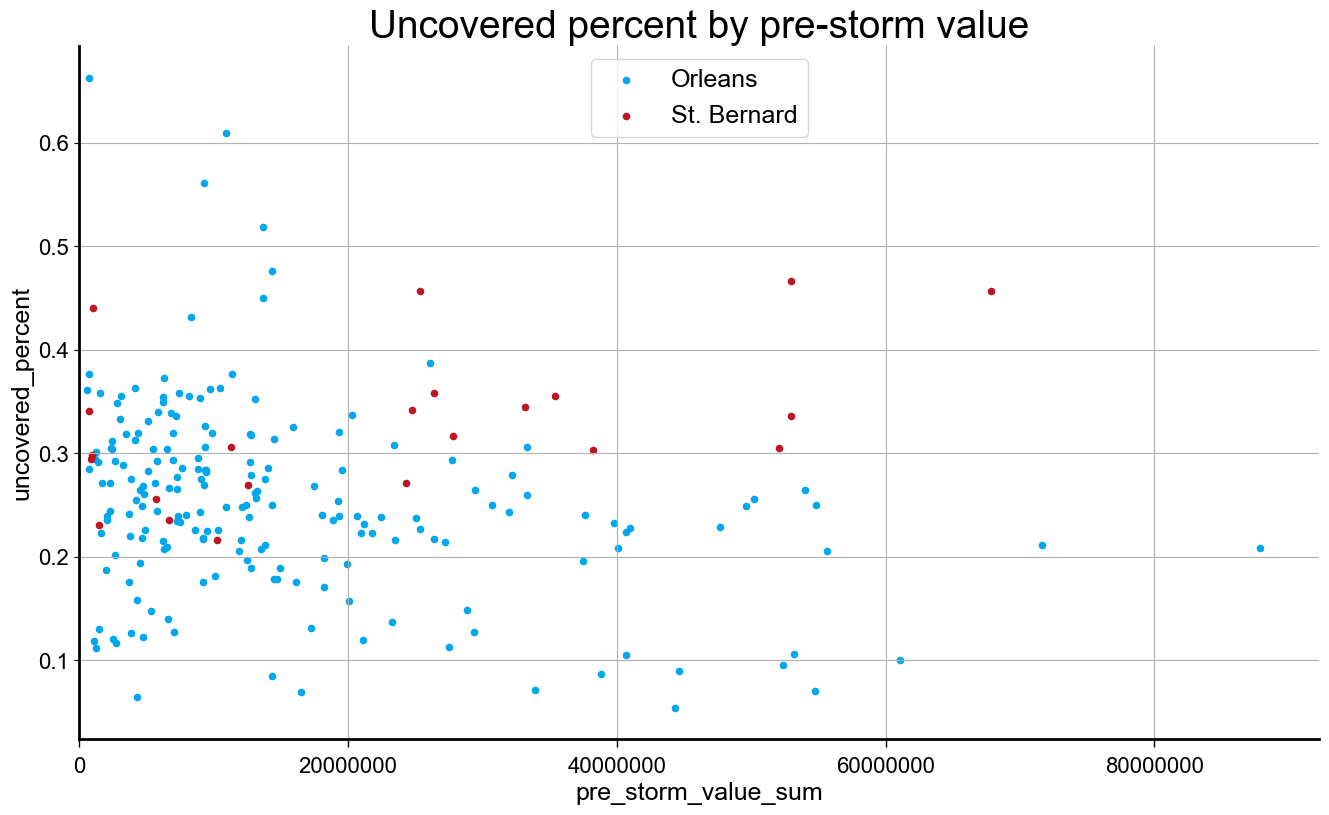

,22071,22087,All
hh_median_income_bin,,,
"(0, 20000]","121,319.73",NaN,"121,319.73"
"(20000, 40000]","139,197.12","131,849.36","137,807.08"
"(40000, 60000]","219,926.00","152,247.05","210,444.61"
"(60000, 80000]","279,492.70","196,442.86","245,978.49"
"(80000, 100000]","303,325.23",NaN,"303,325.23"
"(100000, 110000]","498,285.25",NaN,"498,285.25"


In [158]:
print('Mean pre-storm value by income bracket')

fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00']=='22071'].plot(kind='scatter', y='uncovered_percent', x='pre_storm_value_sum', label='Orleans', ax = ax, color='C0')
rh_bg[rh_bg['CNTYIDFP00']=='22087'].plot(kind='scatter', y='uncovered_percent', x='pre_storm_value_sum', label='St. Bernard', ax = ax, color='C1')
plt.xlim(left=0)
ax.ticklabel_format(style='plain')
plt.title('Uncovered percent by pre-storm value')
plt.legend(loc='upper center')
plt.show()
plt.close()


display(pd.concat(
    [
        (rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])]
        .groupby(['hh_median_income_bin', 'CNTYIDFP00'])
        .agg({
            'pre_storm_value_sum' : 'sum', 
            'all_grants_count' : 'sum'
            })
        .unstack()
        .apply(lambda x : x['pre_storm_value_sum']/x['all_grants_count'], axis=1)),

        (rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])]
        .groupby('hh_median_income_bin')
        .agg({
            'pre_storm_value_sum' : 'sum', 
            'all_grants_count' : 'sum'})
        .apply(lambda x: (x['pre_storm_value_sum']/x['all_grants_count']), axis=1)
        .rename('All'))

    ],
    axis=1
)
)



## Repayment time

Because there is a relationship between the amount of damage left uncovered and the median income, lower-income properties would have had to spend a much longer time working to cover the cost of the uncovered damage.

This is most cleanly seen in the individual block groups (or neighborhoods, if we want to go to that level of aggregation). But it also shows up in the income quintiles.

The effect is most clean in Orleans Parish but shows in the overall numbers and is generally true in St. Bernard as well (though St. Bernard has a longer repayment period in the highest-income quintile than in middle-income quintiles).

Binned data uses the minimum median income in that bin to calculate the maximum repayment time and the maximum median income in the bin to calculate the minimum repayment time.

In [142]:
rh_bg['repayment_time_years'] = rh_bg['uncovered_mean']/rh_bg['hh_median_income']
rh_bg[rh_bg['compensation_sum']>0][['BKGPIDFP00', 'hh_median_income', 'uncovered_mean', 'repayment_time_years']].sort_values(by='repayment_time_years')

,BKGPIDFP00,hh_median_income,uncovered_mean,repayment_time_years
101,220710076041,109861,"16,946.22",0.15
376,220710119001,44063,"13,096.70",0.30
136,220710123003,48125,"17,061.51",0.35
506,220710056021,61765,"24,824.48",0.40
69,220710076032,37900,"16,189.05",0.43
...,...,...,...,...
381,220710070002,9917,"60,884.32",6.14
379,220710102002,12500,"79,712.67",6.38
480,220710094002,8500,"60,679.50",7.14
209,220710031001,17300,"181,345.68",10.48


In [ ]:
repayment_quint = rh_bg.groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).reset_index()
repayment_quint['uncovered_mean'] = repayment_quint['uncovered_sum']/repayment_quint['all_grants_count']
repayment_quint['min_income'] = repayment_quint['hh_median_income_quint'].apply(lambda x: x.left).astype(float)
repayment_quint['max_income'] = repayment_quint['hh_median_income_quint'].apply(lambda x: x.right).astype(float)

# Maximum repayment time is based on minimum income, and visa versa, because higher incomes will repay more quickly.
repayment_quint['repayment_years_min'] = repayment_quint['uncovered_mean']/repayment['max_income']
repayment_quint['repayment_years_max'] = repayment_quint['uncovered_mean']/repayment['min_income']

repayment_quint

,hh_median_income_quint,uncovered_sum,all_grants_count,uncovered_mean,min_income,max_income,repayment_years_min,repayment_years_max
0,"(7444.999, 18650.0]","143,773,926.00","2,306.00","62,347.76","7,445.00","18,650.00",3.12,inf
1,"(18650.0, 25997.2]","168,759,467.71","3,073.00","54,916.85","18,650.00","25,997.20",1.37,2.75
2,"(25997.2, 34621.2]","236,515,846.78","3,964.00","59,665.96","25,997.20","34,621.20",0.99,1.49
3,"(34621.2, 44833.6]","348,050,254.30","6,071.00","57,329.97","34,621.20","44,833.60",0.72,0.96
4,"(44833.6, 109861.0]","419,543,356.86","5,774.00","72,660.78","44,833.60","109,861.00",0.73,0.91


In [ ]:
repayment = rh_bg.groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).reset_index()
repayment['uncovered_mean'] = repayment['uncovered_sum']/repayment['all_grants_count']
repayment['min_income'] = repayment['hh_median_income_bin'].apply(lambda x: x.left).astype(float)
repayment['max_income'] = repayment['hh_median_income_bin'].apply(lambda x: x.right).astype(float)

# Maximum repayment time is based on minimum income, and visa versa, because higher incomes will repay more quickly.
repayment['repayment_years_min'] = repayment['uncovered_mean']/repayment['max_income']
repayment['repayment_years_max'] = repayment['uncovered_mean']/repayment['min_income']

repayment

,hh_median_income_bin,uncovered_sum,all_grants_count,uncovered_mean,min_income,max_income,repayment_years_min,repayment_years_max
0,"(0, 20000]","173,482,128.52","2,890.00","60,028.42",0.00,"20,000.00",3.00,inf
1,"(20000, 40000]","597,009,559.86","10,239.00","58,307.41","20,000.00","40,000.00",1.46,2.92
2,"(40000, 60000]","389,900,276.16","6,475.00","60,216.26","40,000.00","60,000.00",1.00,1.51
3,"(60000, 80000]","154,761,644.50","1,524.00","101,549.64","60,000.00","80,000.00",1.27,1.69
4,"(80000, 100000]","10,410,986.96",36.00,"289,194.08","80,000.00","100,000.00",2.89,3.61
5,"(100000, 110000]","1,508,213.90",89.00,"16,946.22","100,000.00","110,000.00",0.15,0.17


In [136]:
repayment_quint = rh_bg[rh_bg['CNTYIDFP00']=='22071'].groupby('hh_median_income_quint_orleans').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).reset_index()
repayment_quint['uncovered_mean'] = repayment_quint['uncovered_sum']/repayment_quint['all_grants_count']
repayment_quint['min_income'] = repayment_quint['hh_median_income_quint_orleans'].apply(lambda x: x.left).astype(float)
repayment_quint['max_income'] = repayment_quint['hh_median_income_quint_orleans'].apply(lambda x: x.right).astype(float)

# Maximum repayment time is based on minimum income, and visa versa, because higher incomes will repay more quickly.
repayment_quint['repayment_years_min'] = repayment_quint['uncovered_mean']/repayment['max_income']
repayment_quint['repayment_years_max'] = repayment_quint['uncovered_mean']/repayment['min_income']

print('Orleans Parish only.')
display(repayment_quint)

Orleans Parish only.


,hh_median_income_quint_orleans,uncovered_sum,all_grants_count,uncovered_mean,min_income,max_income,repayment_years_min,repayment_years_max
0,"(7444.999, 18069.6]","127,742,014.70","2,047.00","62,404.50","7,445.00","18,069.60",3.12,inf
1,"(18069.6, 24477.8]","149,323,858.81","2,670.00","55,926.54","18,069.60","24,477.80",1.40,2.80
2,"(24477.8, 32107.0]","182,660,349.56","3,458.00","52,822.54","24,477.80","32,107.00",0.88,1.32
3,"(32107.0, 44492.6]","241,607,016.31","4,518.00","53,476.54","32,107.00","44,492.60",0.67,0.89
4,"(44492.6, 109861.0]","290,741,250.64","5,045.00","57,629.58","44,492.60","109,861.00",0.58,0.72


In [137]:
repayment_quint = rh_bg[rh_bg['CNTYIDFP00']=='22087'].groupby('hh_median_income_quint_st_bernard').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).reset_index()
repayment_quint['uncovered_mean'] = repayment_quint['uncovered_sum']/repayment_quint['all_grants_count']
repayment_quint['min_income'] = repayment_quint['hh_median_income_quint_st_bernard'].apply(lambda x: x.left).astype(float)
repayment_quint['max_income'] = repayment_quint['hh_median_income_quint_st_bernard'].apply(lambda x: x.right).astype(float)

# Maximum repayment time is based on minimum income, and visa versa, because higher incomes will repay more quickly.
repayment_quint['repayment_years_min'] = repayment_quint['uncovered_mean']/repayment['max_income']
repayment_quint['repayment_years_max'] = repayment_quint['uncovered_mean']/repayment['min_income']

print('St. Bernard Parish only.')
display(repayment_quint)

St. Bernard Parish only.


,hh_median_income_quint_st_bernard,uncovered_sum,all_grants_count,uncovered_mean,min_income,max_income,repayment_years_min,repayment_years_max
0,"(23749.999, 31968.8]","21,403,480.28",326.00,"65,654.85","23,750.00","31,968.80",3.28,inf
1,"(31968.8, 33745.8]","61,109,123.78",637.00,"95,932.69","31,968.80","33,745.80",2.40,4.80
2,"(33745.8, 39435.8]","68,136,365.00",967.00,"70,461.60","33,745.80","39,435.80",1.17,1.76
3,"(39435.8, 52868.0]","23,641,467.04",324.00,"72,967.49","39,435.80","52,868.00",0.91,1.22
4,"(52868.0, 67067.0]","150,277,925.53","1,196.00","125,650.44","52,868.00","67,067.00",1.26,1.57


## Race

An analysis of race really only makes sense in New Orleans, since St. Bernard's population was nearly entirely White at the time of Katrina. Note that quintile binning for Orleans only yields four categories for white_percent because so many block groups have near zero White population.

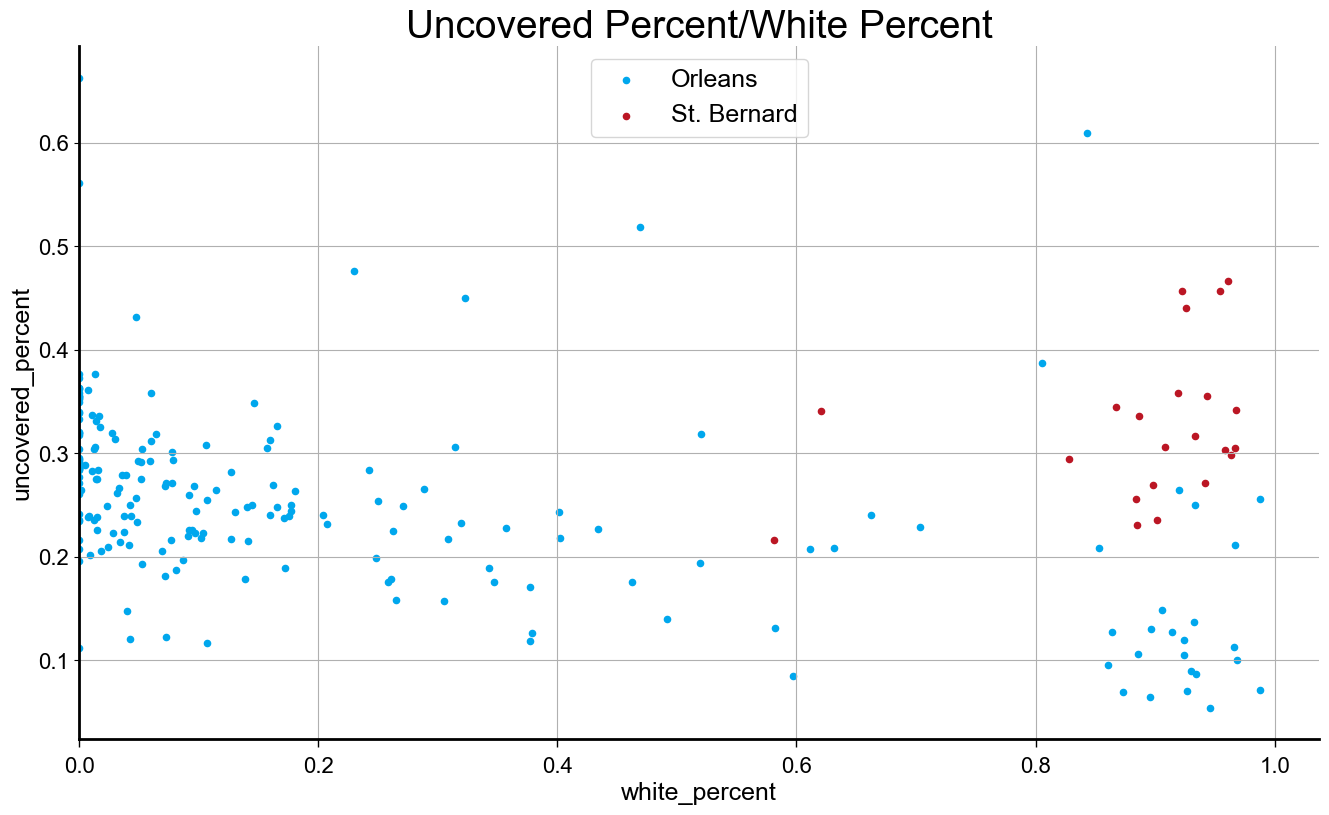

In [151]:
fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00']=='22071'].plot(kind='scatter', y='uncovered_percent', x='white_percent', label='Orleans', ax = ax, color='C0')
rh_bg[rh_bg['CNTYIDFP00']=='22087'].plot(kind='scatter', y='uncovered_percent', x='white_percent', label='St. Bernard', ax = ax, color='C1')
plt.xlim(left=0)
plt.title('Uncovered Percent/White Percent')
plt.legend(loc='upper center')
plt.show()
plt.close()

In [148]:
race = rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('white_percent_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'})
race['uncovered_percent'] = race['uncovered_sum']/race['damage_sum']
race

,uncovered_sum,damage_sum,uncovered_percent
white_percent_bins,,,
"(0.0, 0.2]","421,255,106.28","1,648,630,690.68",0.26
"(0.2, 0.4]","154,336,618.22","613,969,689.19",0.25
"(0.4, 0.6]","33,668,827.05","129,207,550.13",0.26
"(0.6, 0.8]","37,501,688.65","166,925,252.61",0.22
"(0.8, 1.0]","142,670,906.05","839,524,927.88",0.17


In [149]:
race = rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('white_percent_quint_orleans').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'})
race['uncovered_percent'] = race['uncovered_sum']/race['damage_sum']
race

,uncovered_sum,damage_sum,uncovered_percent
white_percent_quint_orleans,,,
"(-0.001, 0.0452]","394,231,390.42","1,377,043,454.72",0.29
"(0.0452, 0.136]","155,560,081.48","616,366,542.17",0.25
"(0.136, 0.378]","228,189,002.81","910,723,589.56",0.25
"(0.378, 0.988]","214,094,015.31","1,137,653,971.05",0.19


## Tables

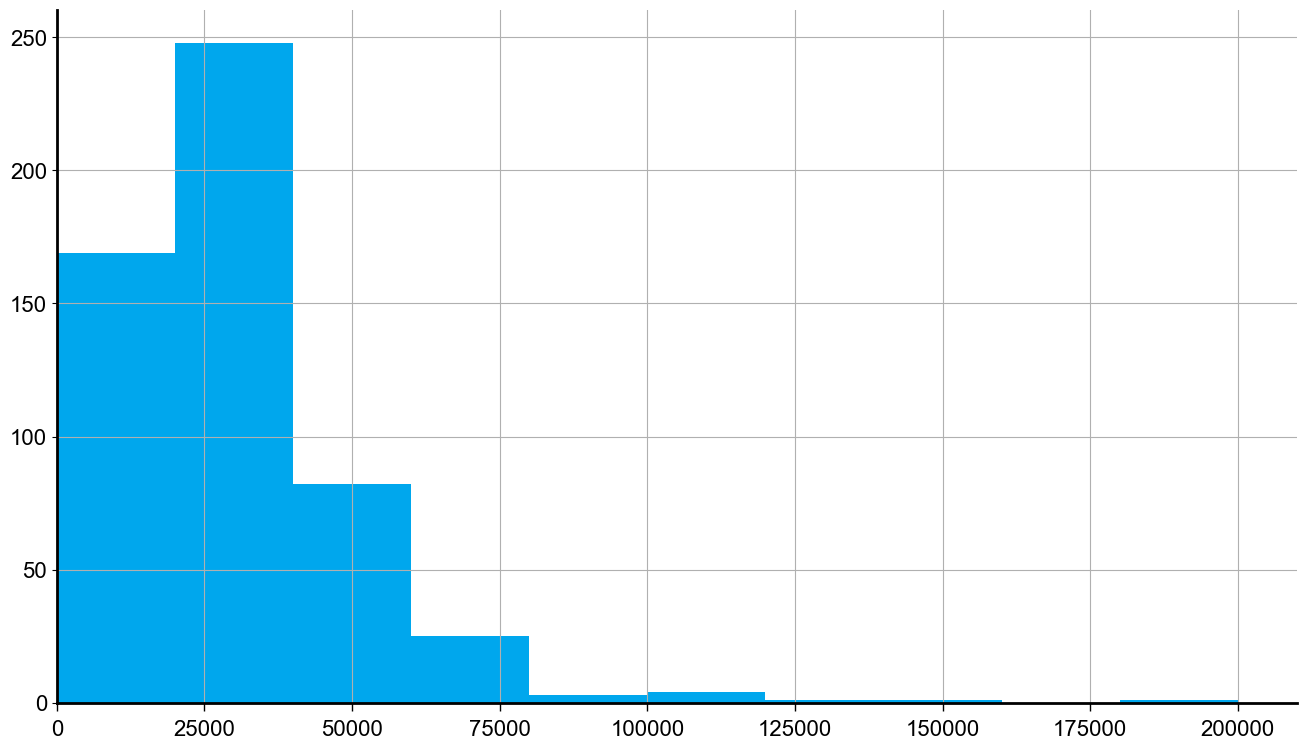

In [22]:
fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00'].isin(['22071','22087'])]['hh_median_income'].hist(ax=ax)
plt.xlim(left=0)
plt.show()
plt.close()

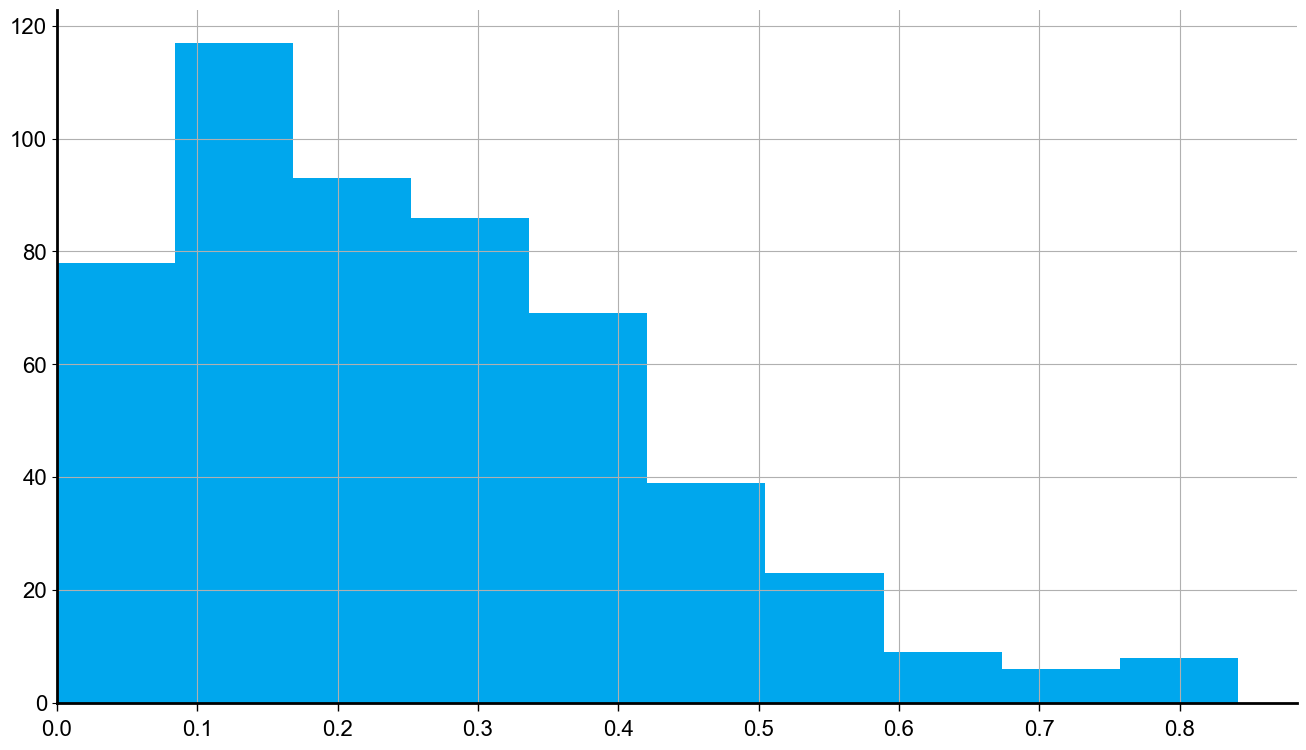

In [23]:
fig, ax = plt.subplots()
rh_bg[rh_bg['CNTYIDFP00'].isin(['22071','22087'])]['percent_poverty_status'].hist(ax=ax)
plt.xlim(left=0)
plt.show()
plt.close()